## dctcompression1.ipynb

In [1]:
datasetinfo = { "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "datadir":"../data/",
                "metadatadir":"../data/metadata/",
                "extension":"tif"
              }
import sys
sys.path.insert(0,"../cropseg/")

In [2]:
tileid = "003186"

import numpy
from osgeo import gdal
from mlhubdata import loadjson
from grounddata import getFieldMasks

groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundcollection"]}_id.json')
tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/labels.{datasetinfo["extension"]}')
tiledata = numpy.array(tile.GetRasterBand(1).ReadAsArray(),dtype='int')
crops = numpy.unique(tiledata[tiledata != 0])
erosioniterations = 2
fieldmasks = getFieldMasks(tiledata,erosioniterations)

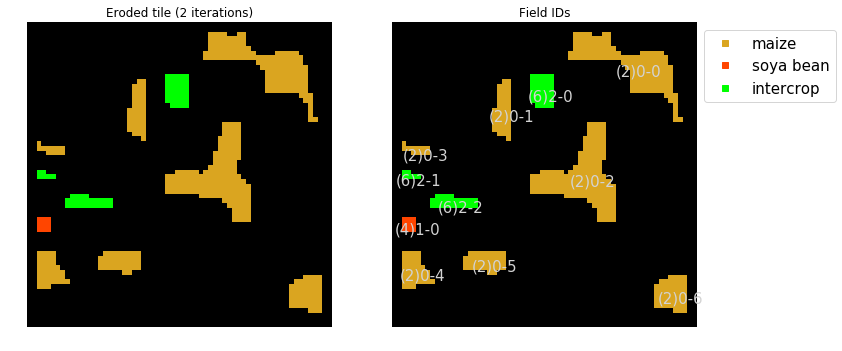

In [4]:
import matplotlib.pyplot
import scipy.ndimage
from PIL import ImageColor

fig,ax = matplotlib.pyplot.subplots(1,2,figsize=[12,8])
axs = ax.ravel()
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype='int')  
for i in range(len(fieldmasks)):
    axs[1].plot(0,0,'s',color=groundlabels[crops[i]]['colour'],label=groundlabels[crops[i]]['crop'],zorder=0)
    colour = ImageColor.getcolor(groundlabels[crops[i]]['colour'],"RGB")
    for j in range(1,fieldmasks[i][1]+1):
        com = scipy.ndimage.center_of_mass(fieldmasks[i][0] == j)
        axs[1].text(com[1]-3,com[0]+2,s=f'({crops[i]}){i}-{j-1}',color='lightgrey',size=15,zorder=10)
        rgb[fieldmasks[i][0] == j,0] = colour[0]
        rgb[fieldmasks[i][0] == j,1] = colour[1]
        rgb[fieldmasks[i][0] == j,2] = colour[2]
axs[0].imshow(rgb,interpolation=None,aspect='equal',zorder=5)
axs[1].imshow(rgb,interpolation=None,aspect='equal',zorder=5)
axs[0].set_title(f'Eroded tile ({erosioniterations} iterations)')
axs[1].set_title(f'Field IDs')
axs[1].legend(bbox_to_anchor=(1.0,1.0),loc='upper left',fontsize=15)
axs[0].axis('off')
axs[1].axis('off')
matplotlib.pyplot.show()

In [5]:
import datetime
from mlhubdata import getItemsFromCollection

s1items = getItemsFromCollection(tileid,datasetinfo["s1collection"],datasetinfo)
s2items = getItemsFromCollection(tileid,datasetinfo["s2collection"],datasetinfo)
s1items = sorted(s1items,key=lambda k:k["properties"]["datetime"])
s2items = sorted(s2items,key=lambda k:k["properties"]["datetime"])
s1dates = []
s2dates = []
for i in range(len(s1items)):
    s1dates.append(datetime.datetime.strptime(s1items[i]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())   
for i in range(len(s2items)):
    s2dates.append(datetime.datetime.strptime(s2items[i]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())

Items for su_african_crops_ghana_source_s1_003186 are available                                                          
Items for su_african_crops_ghana_source_s2_003186 are available                                                          


In [6]:
from satellitedata import getEOIndicies
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]      
s2bands = [
            {"band":"blue","idx":0},
            {"band":"green","idx":1},
            {"band":"red","idx":2},
            {"band":"rded1","idx":3},
            {"band":"rded2","idx":4},
            {"band":"rded3","idx":5},
            {"band":"nir","idx":6},
            {"band":"rded4","idx":7},
            {"band":"swir1","idx":8},
            {"band":"swir2","idx":9}
          ]
s1idxs = ["vhvv"]
s2idxs = ["ndvi","gndvi","gci","rdedci","ndmi"]
s1data = numpy.zeros([len(s1items),len(s1bands),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
s2data = numpy.zeros([len(s2items),len(s2bands),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
s2cloudmasks = numpy.zeros([len(s2items),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]],dtype='int')
for i in range(len(s1items)):
    tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s1collection"]}/{s1items[i]["id"]}/source.{datasetinfo["extension"]}')    
    for j in range(len(s1bands)):
        s1data[i][j] = tile.GetRasterBand(j+1).ReadAsArray()
for i in range(len(s2items)):
    tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s2collection"]}/{s2items[i]["id"]}/source.{datasetinfo["extension"]}')    
    mask = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s2collection"]}/{s2items[i]["id"]}/cloudmask.{datasetinfo["extension"]}')
    for j in range(len(s2bands)):
        s2data[i][j] = tile.GetRasterBand(j+1).ReadAsArray()
    s2cloudmasks[i] = mask.GetRasterBand(1).ReadAsArray()
s1indices = getEOIndicies(s1data,s1bands,s1idxs)
s2indices = getEOIndicies(s2data,s2bands,s2idxs)

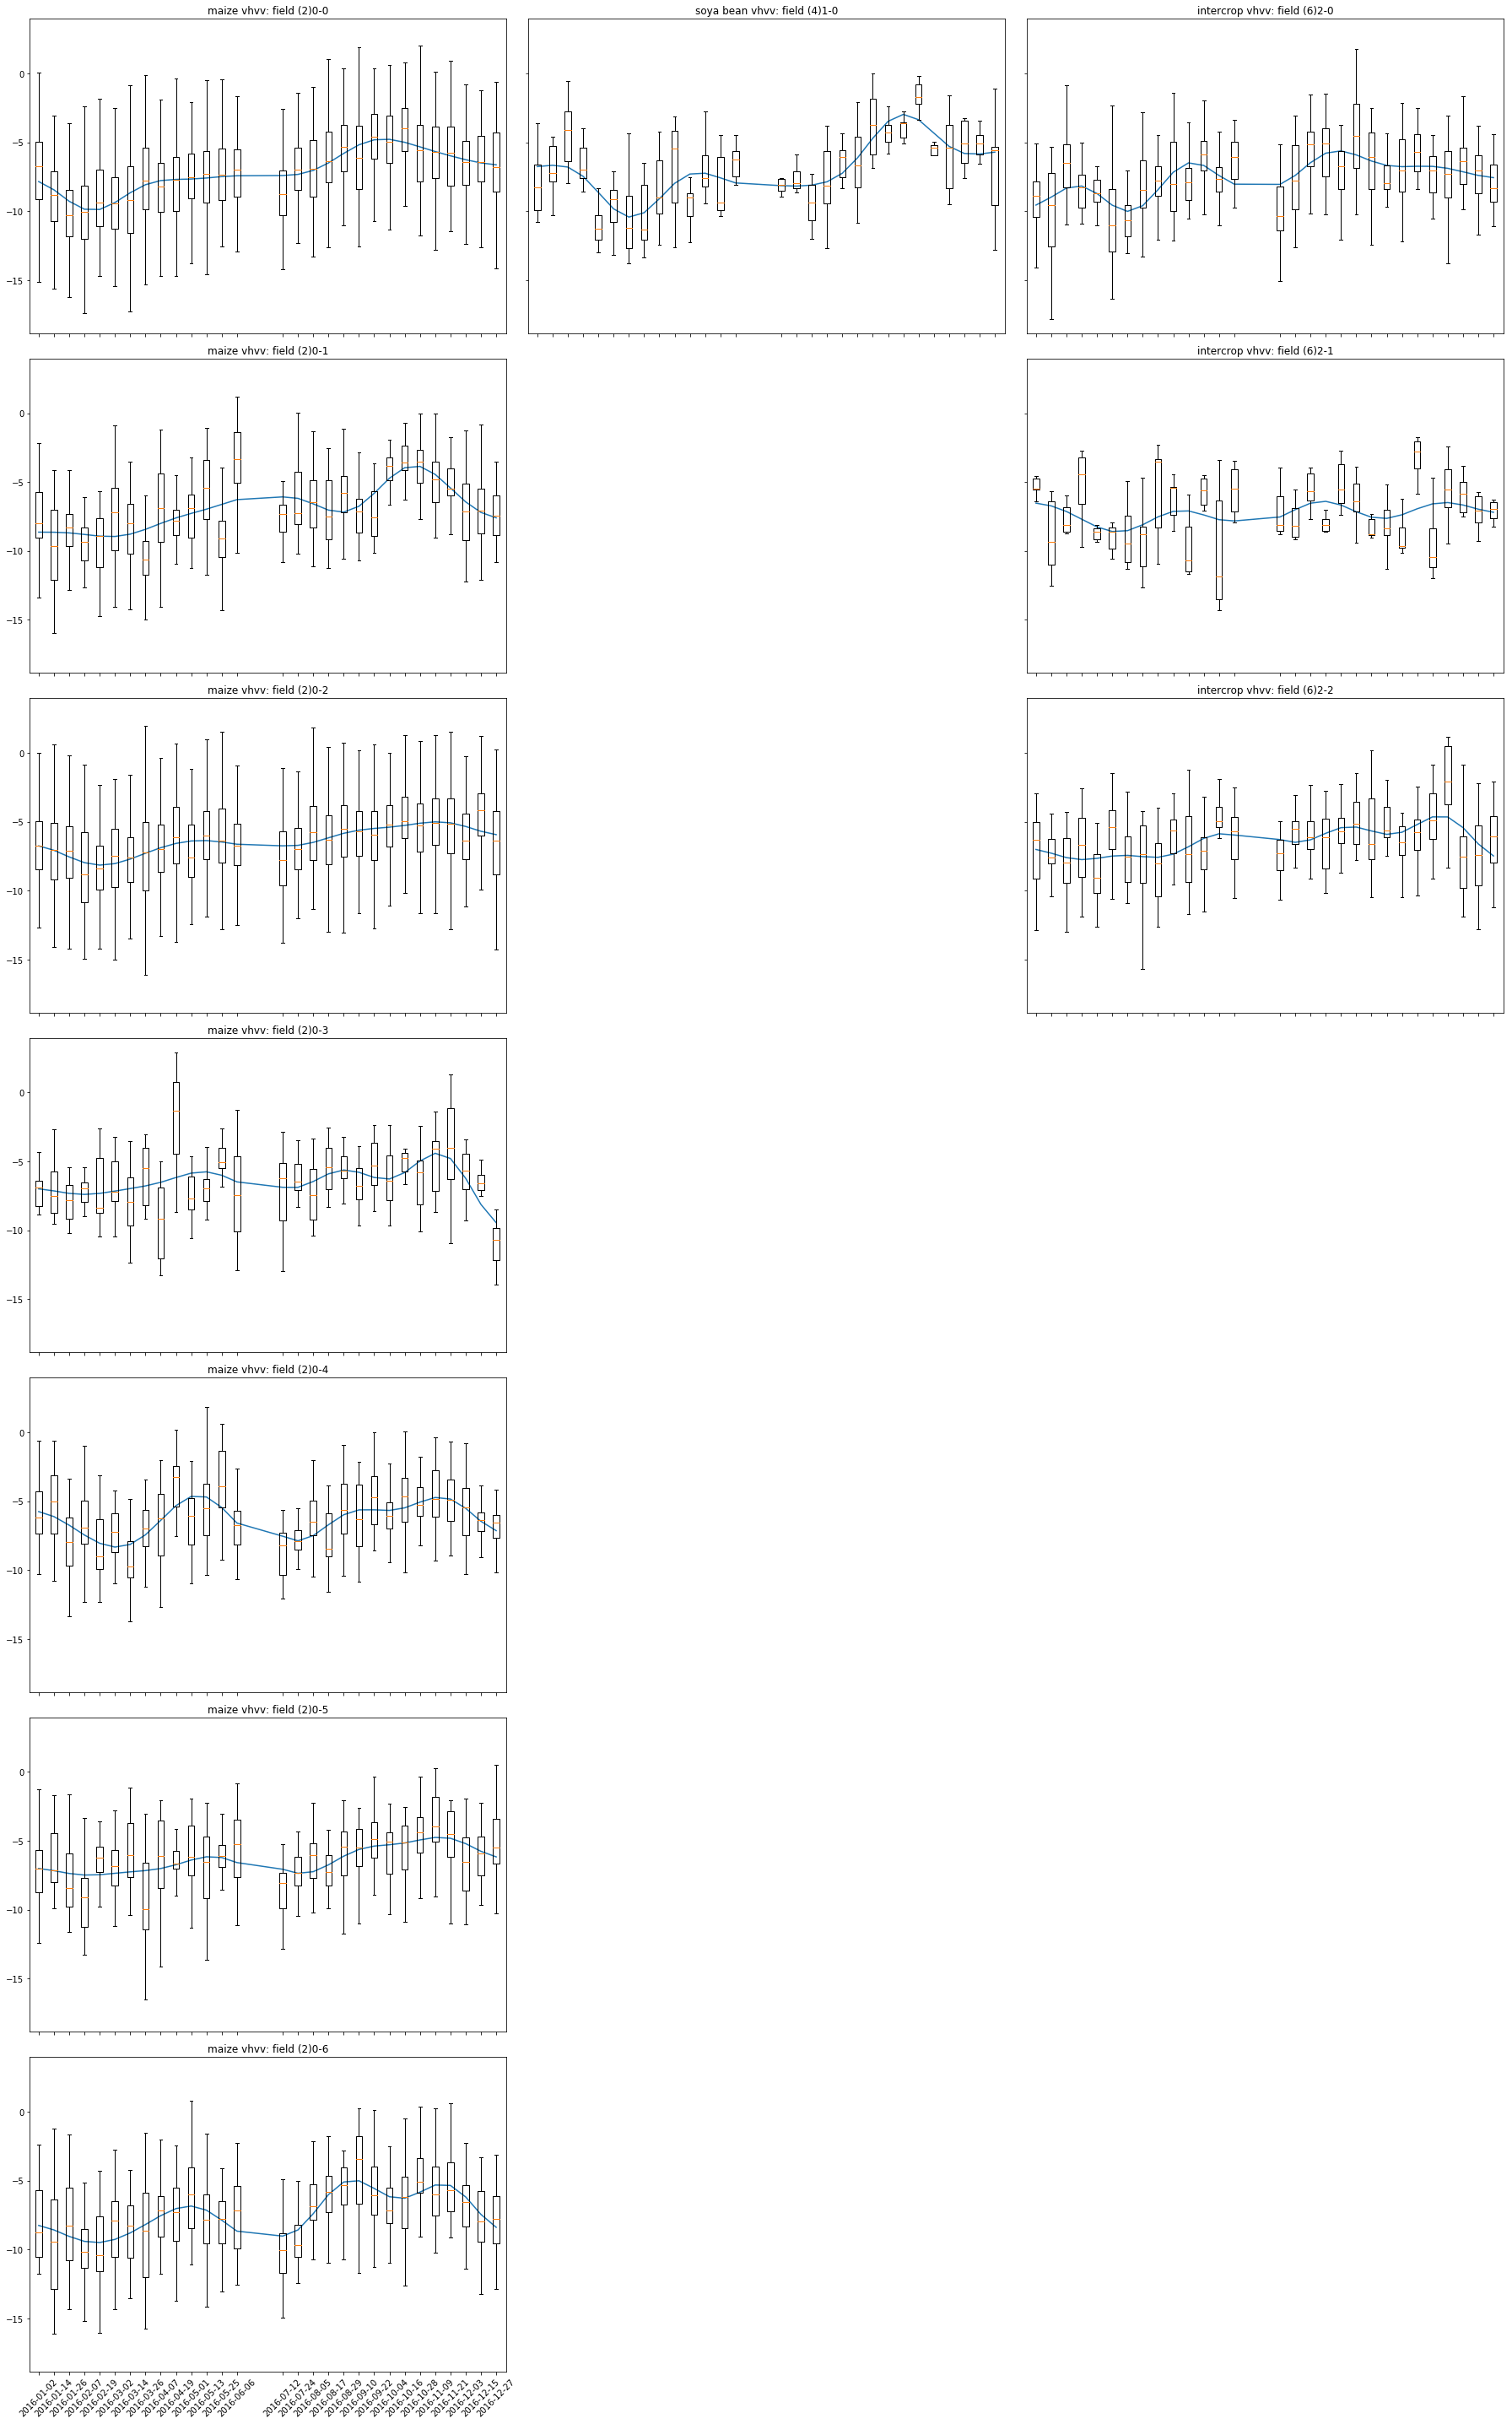

In [7]:
import matplotlib.pyplot
from plotting import datepositions
import scipy.fftpack

ncoeff = 10
s1idx = 0

ncol = 0
nrow = 0
for i in range(len(fieldmasks)):
    if fieldmasks[i][1] > 0:
        ncol = ncol + 1
    if fieldmasks[i][1] > nrow:
        nrow = fieldmasks[i][1]
fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[25,40],sharex="all",sharey="all")
axs = ax.ravel(order='F')
idx = 0
delete = []
for i in range(ncol):
    for j in range(nrow):
        if j < fieldmasks[i][1]:
            data = [[],[],[]]
            for k in range(len(s1indices)):
                fm = numpy.copy(fieldmasks[i][0])
                data[0].append(s1dates[k])
                data[1].append(s1indices[k][s1idx][fm == j+1])
                data[2].append(numpy.mean(s1indices[k][s1idx][fm == j+1]))
            dpos = datepositions(data[0],yearstart=True)
            dct = scipy.fftpack.dct(data[2],norm="ortho",type=2)
            coefficients = numpy.zeros(len(dpos))
            coefficients[:ncoeff] = 1
            coefficients = dct * coefficients
            idct = scipy.fftpack.idct(coefficients,norm="ortho",type=2)
            axs[idx].plot(dpos,idct)
            axs[idx].boxplot(data[1],positions=dpos,widths=5,showfliers=False)
            axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s1idxs[s1idx]}: field ({crops[i]}){i}-{j}')
            axs[idx].set_xticklabels(data[0],rotation=45)
            axs[idx].set_xlim(-5,370)
        else:
            delete.append(idx)
        idx = idx + 1
for i in range(len(delete)):
    fig.delaxes(axs[delete[i]])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

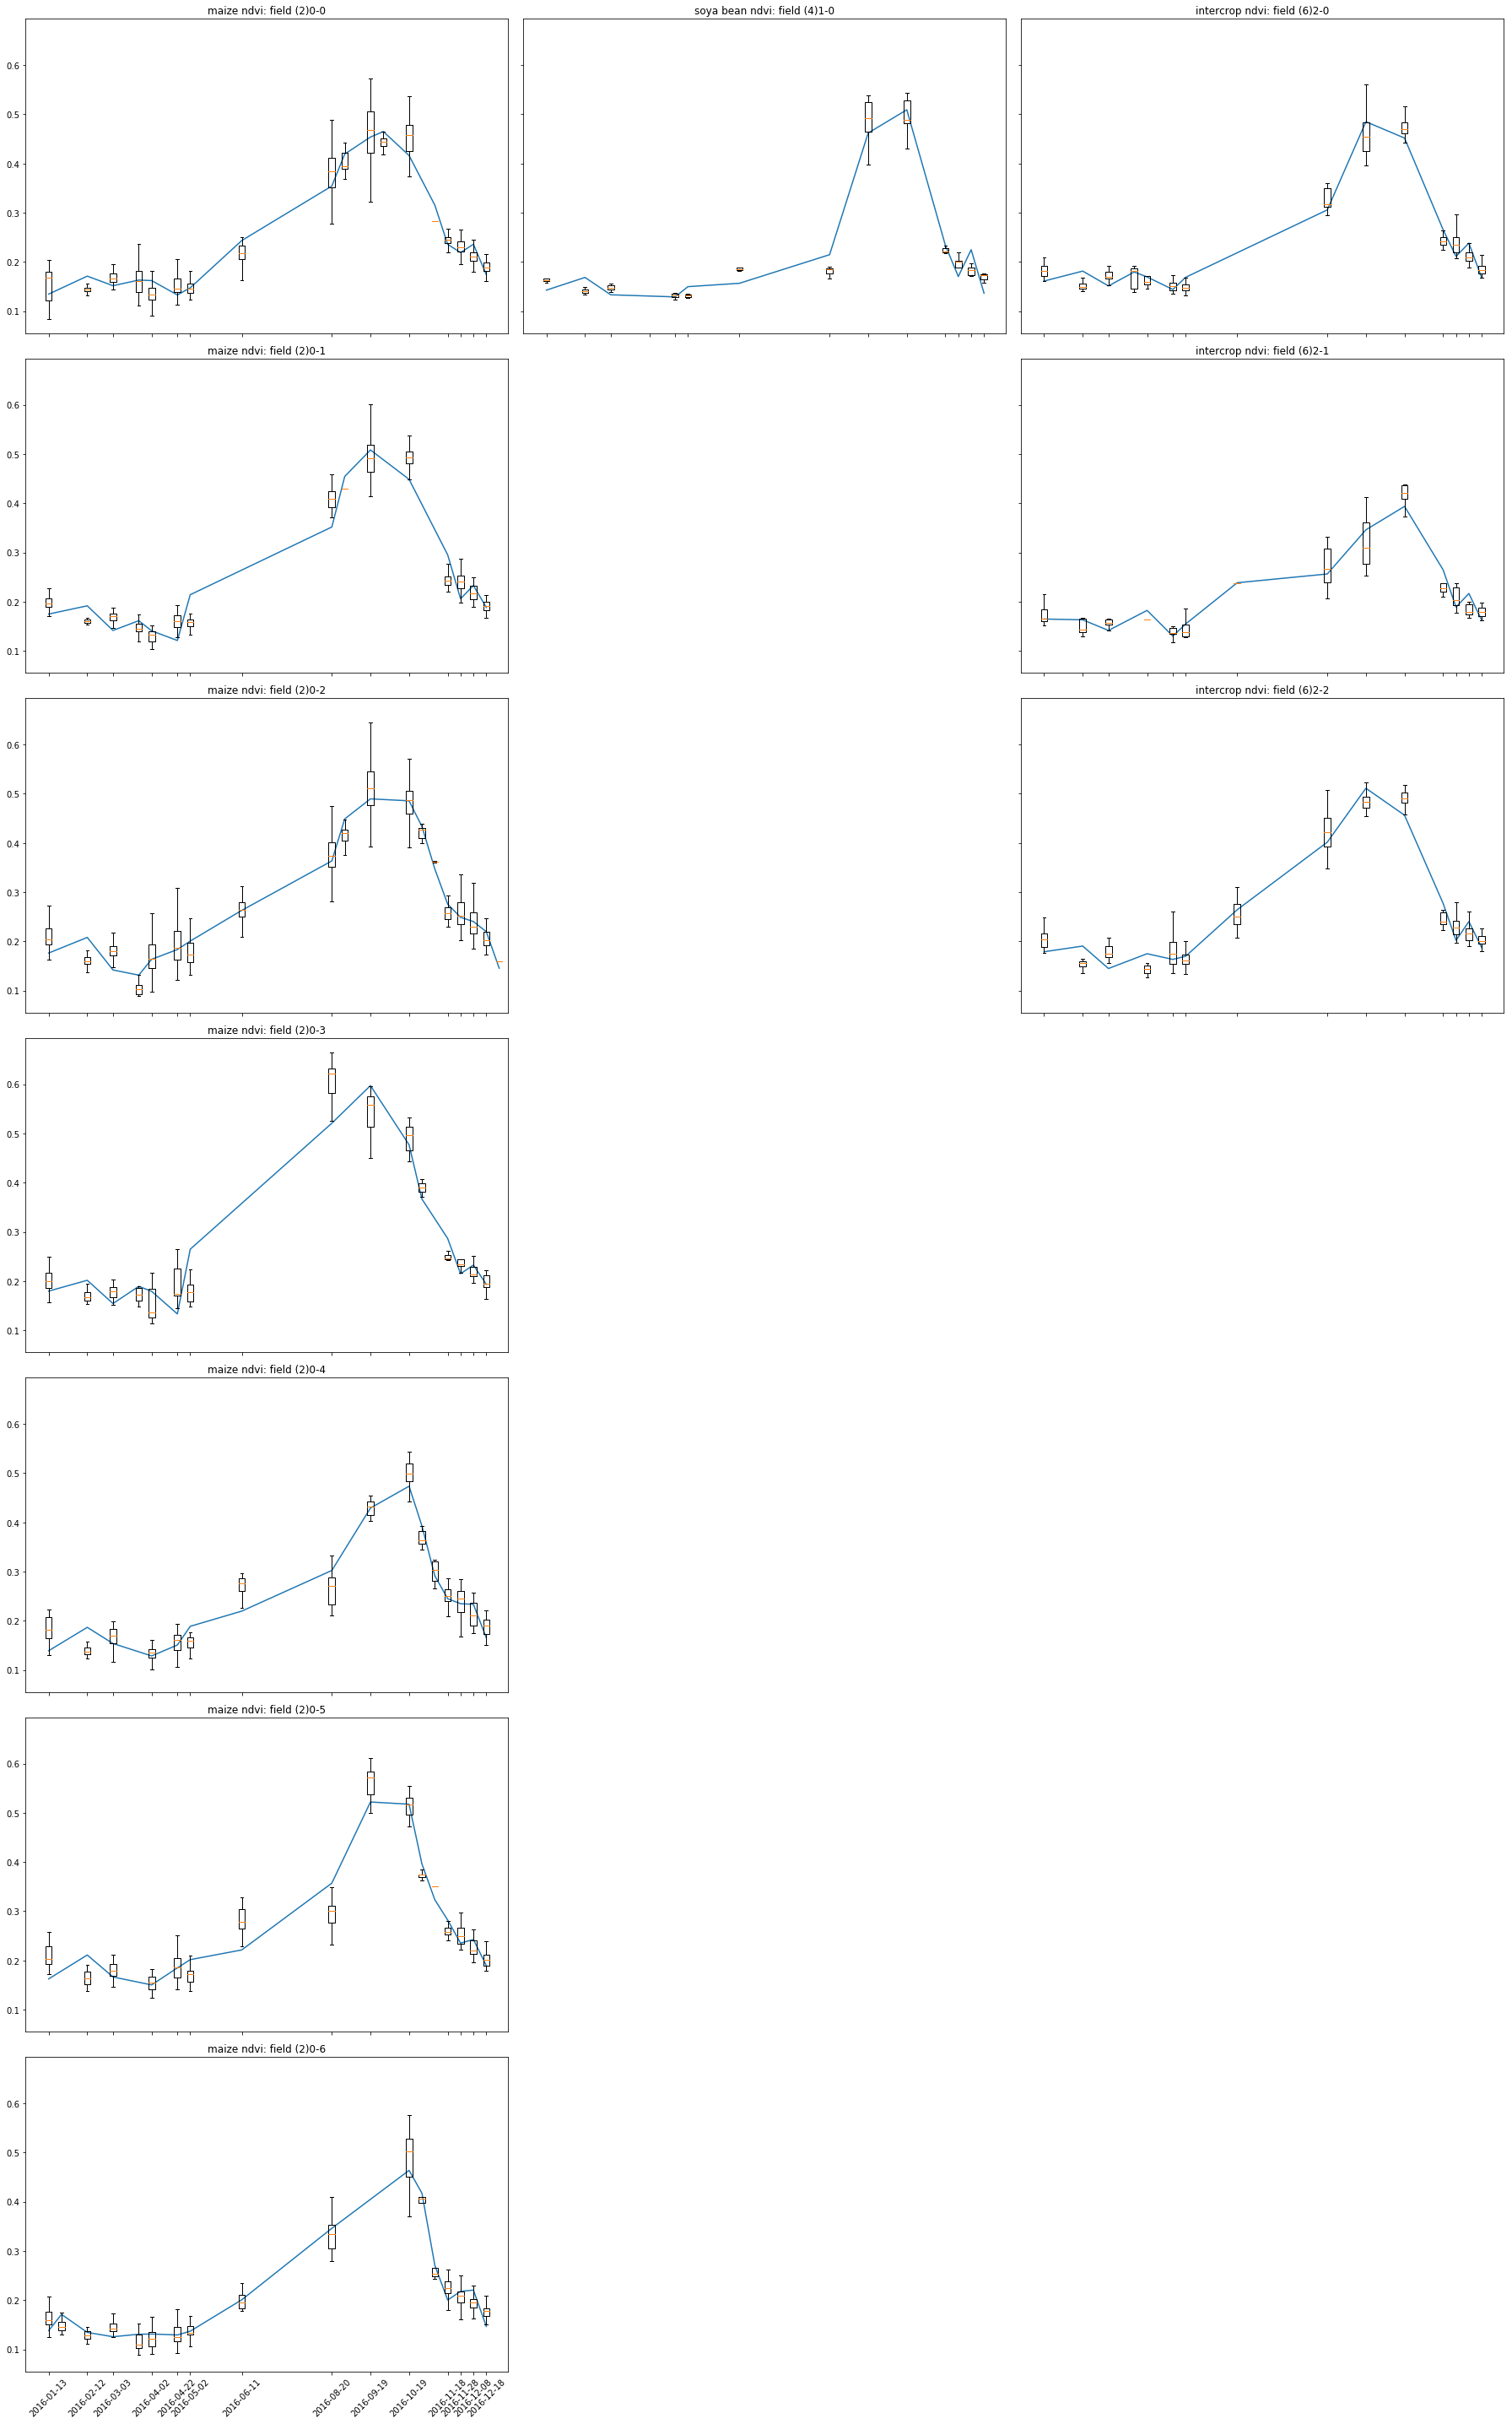

In [8]:
def plotS2VI(fieldmasks,s2indices,s2dates,vi,ncoeff):
    ncol = 0
    nrow = 0
    for i in range(len(fieldmasks)):
        if fieldmasks[i][1] > 0:
            ncol = ncol + 1
        if fieldmasks[i][1] > nrow:
            nrow = fieldmasks[i][1]
    fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[25,40],sharex="all",sharey="all")
    axs = ax.ravel(order='F')
    idx = 0
    delete = []
    for i in range(ncol):
        for j in range(nrow):
            if j < fieldmasks[i][1]:
                data = [[],[],[]]
                for k in range(len(s2indices)):
                    fm = numpy.copy(fieldmasks[i][0])
                    fm[s2cloudmasks[k] != 0] = 0
                    if len(s2indices[k][0][fm == j+1]) > 0:
                        data[0].append(s2dates[k])
                        data[1].append(s2indices[k][vi][fm == j+1])
                        data[2].append(numpy.mean(s2indices[k][vi][fm == j+1]))
                dpos = datepositions(data[0],yearstart=True)
                dct = scipy.fftpack.dct(data[2],norm="ortho",type=1)
                coefficients = numpy.zeros(len(dpos))
                coefficients[:ncoeff] = 1
                coefficients = dct * coefficients
                idct = scipy.fftpack.idct(coefficients,norm="ortho",type=1)
                axs[idx].plot(dpos,idct)
                axs[idx].boxplot(data[1],positions=dpos,widths=5,showfliers=False)
                axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s2idxs[vi]}: field ({crops[i]}){i}-{j}')
                axs[idx].set_xticklabels(data[0],rotation=45)
                axs[idx].set_xlim(-5,370)
            else:
                delete.append(idx)
            idx = idx + 1
    for i in range(len(delete)):
        fig.delaxes(axs[delete[i]])
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
plotS2VI(fieldmasks,s2indices,s2dates,0,10)

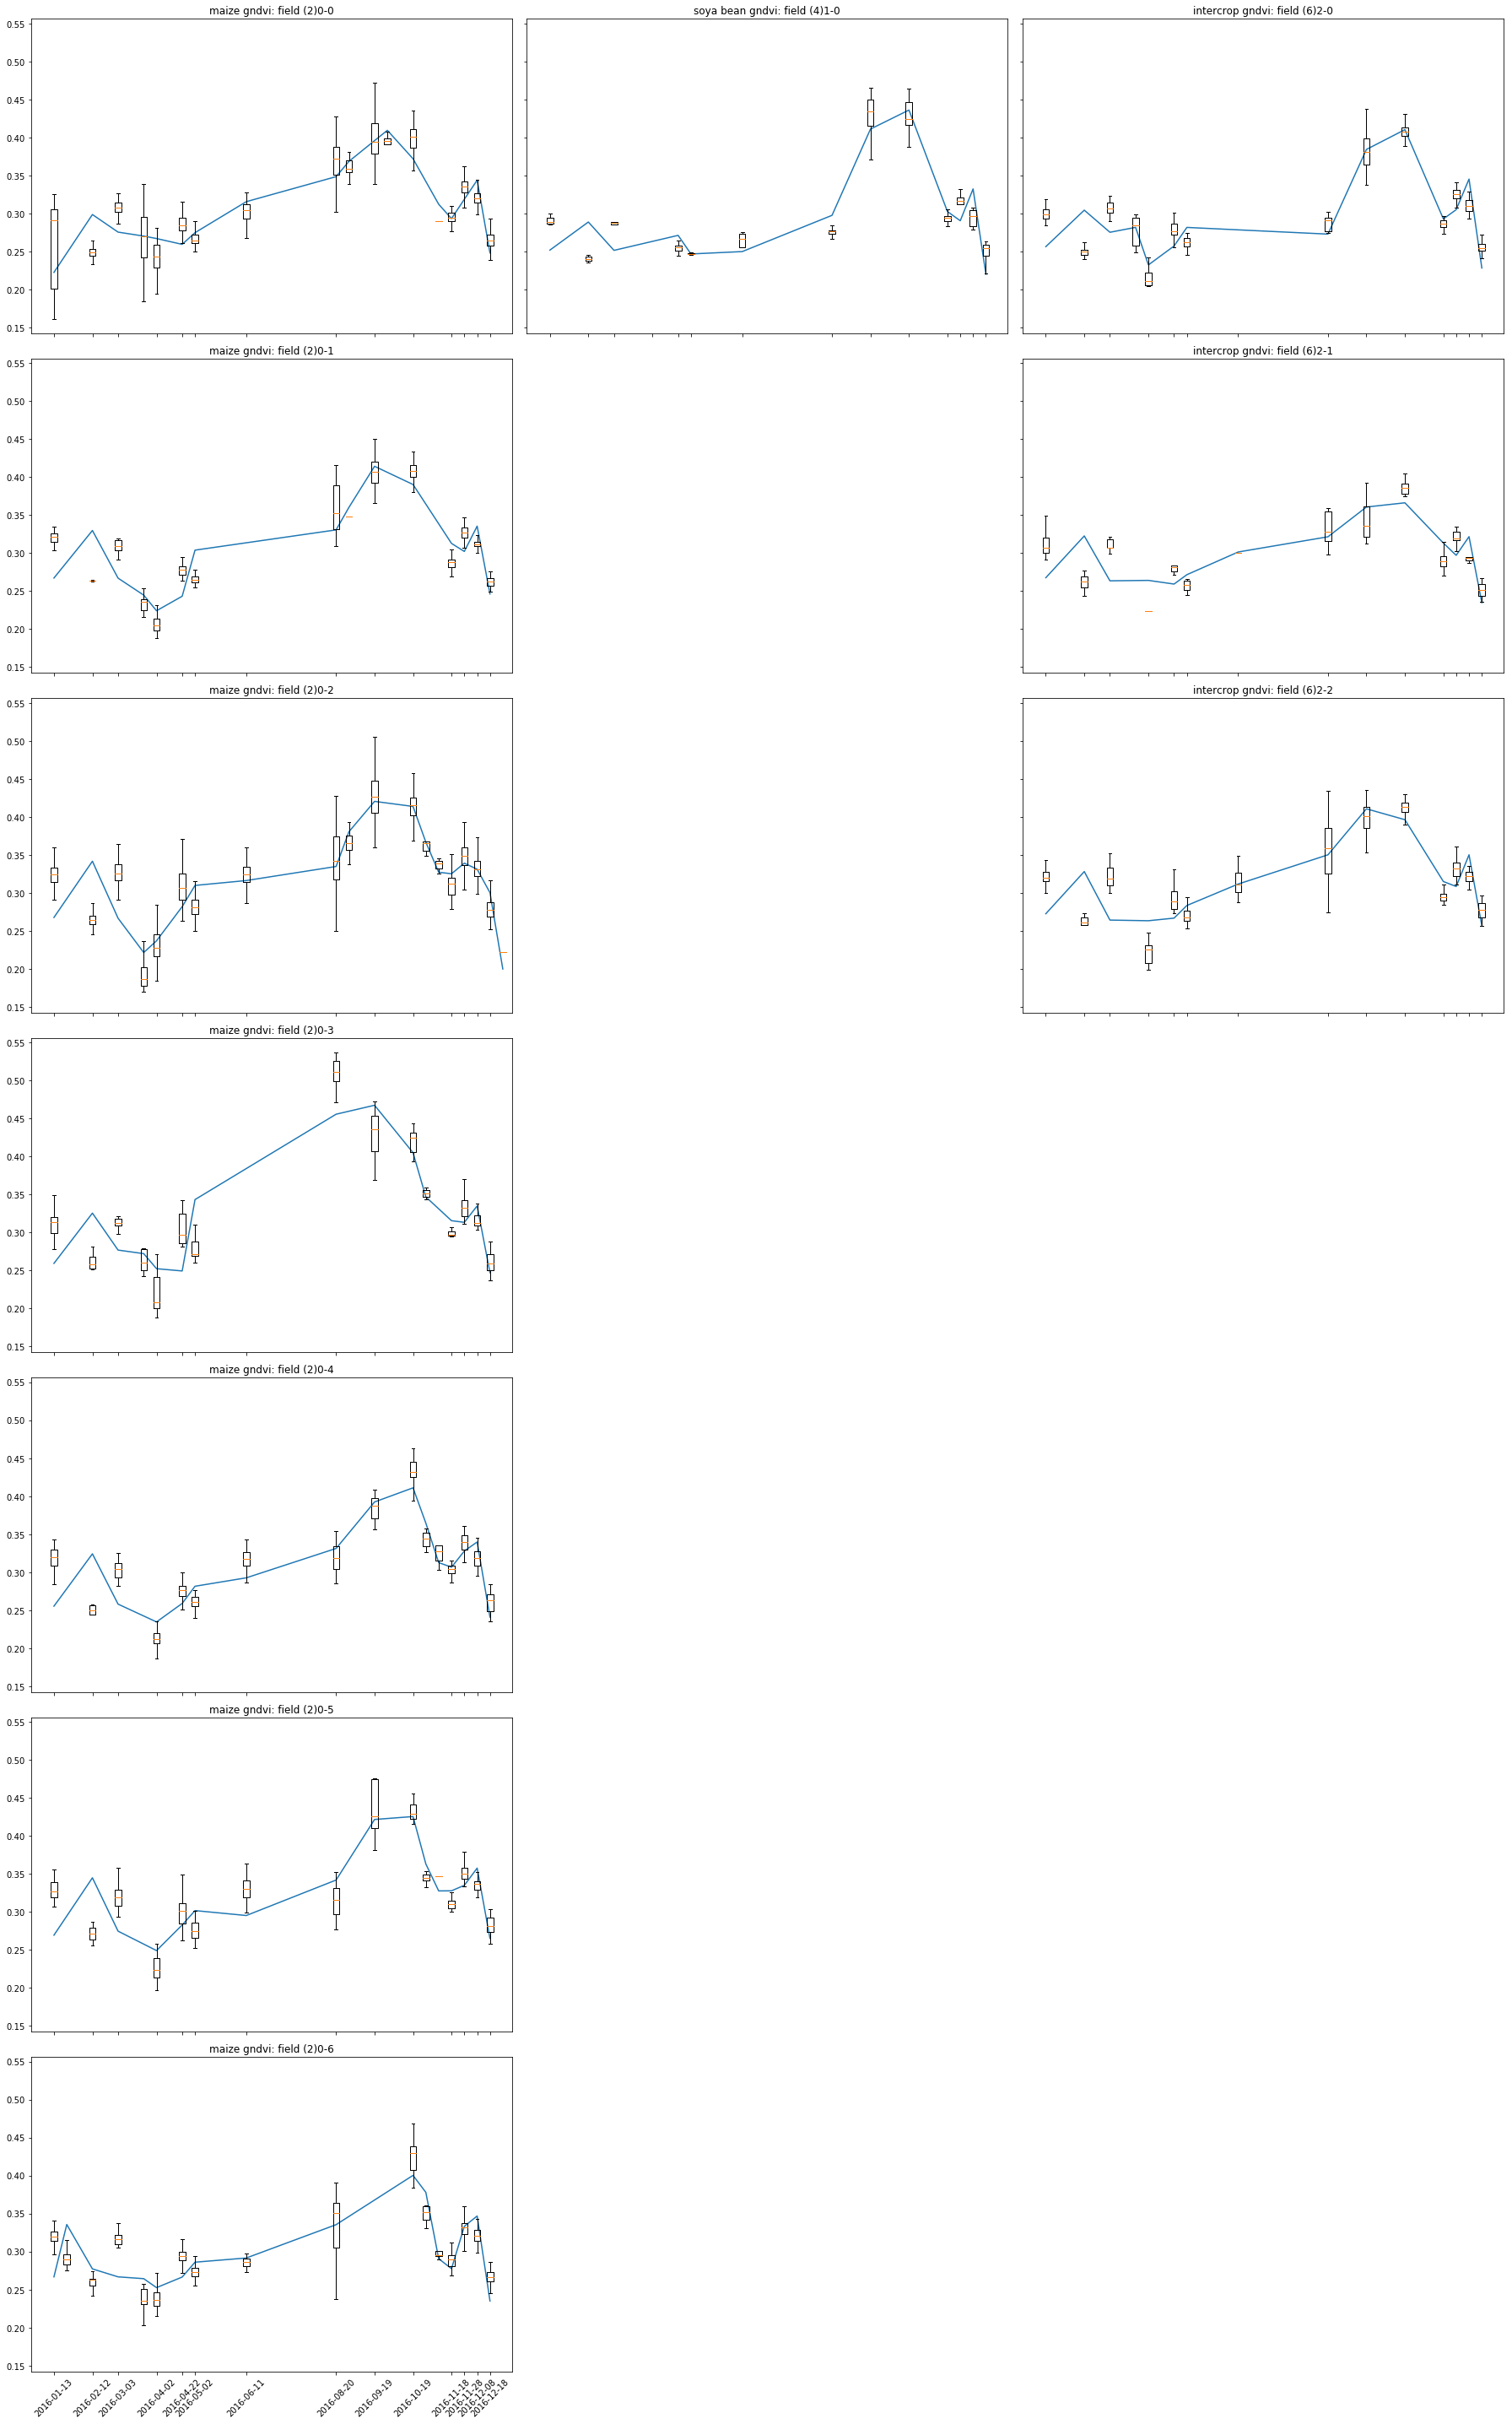

In [9]:
plotS2VI(fieldmasks,s2indices,s2dates,1,10)

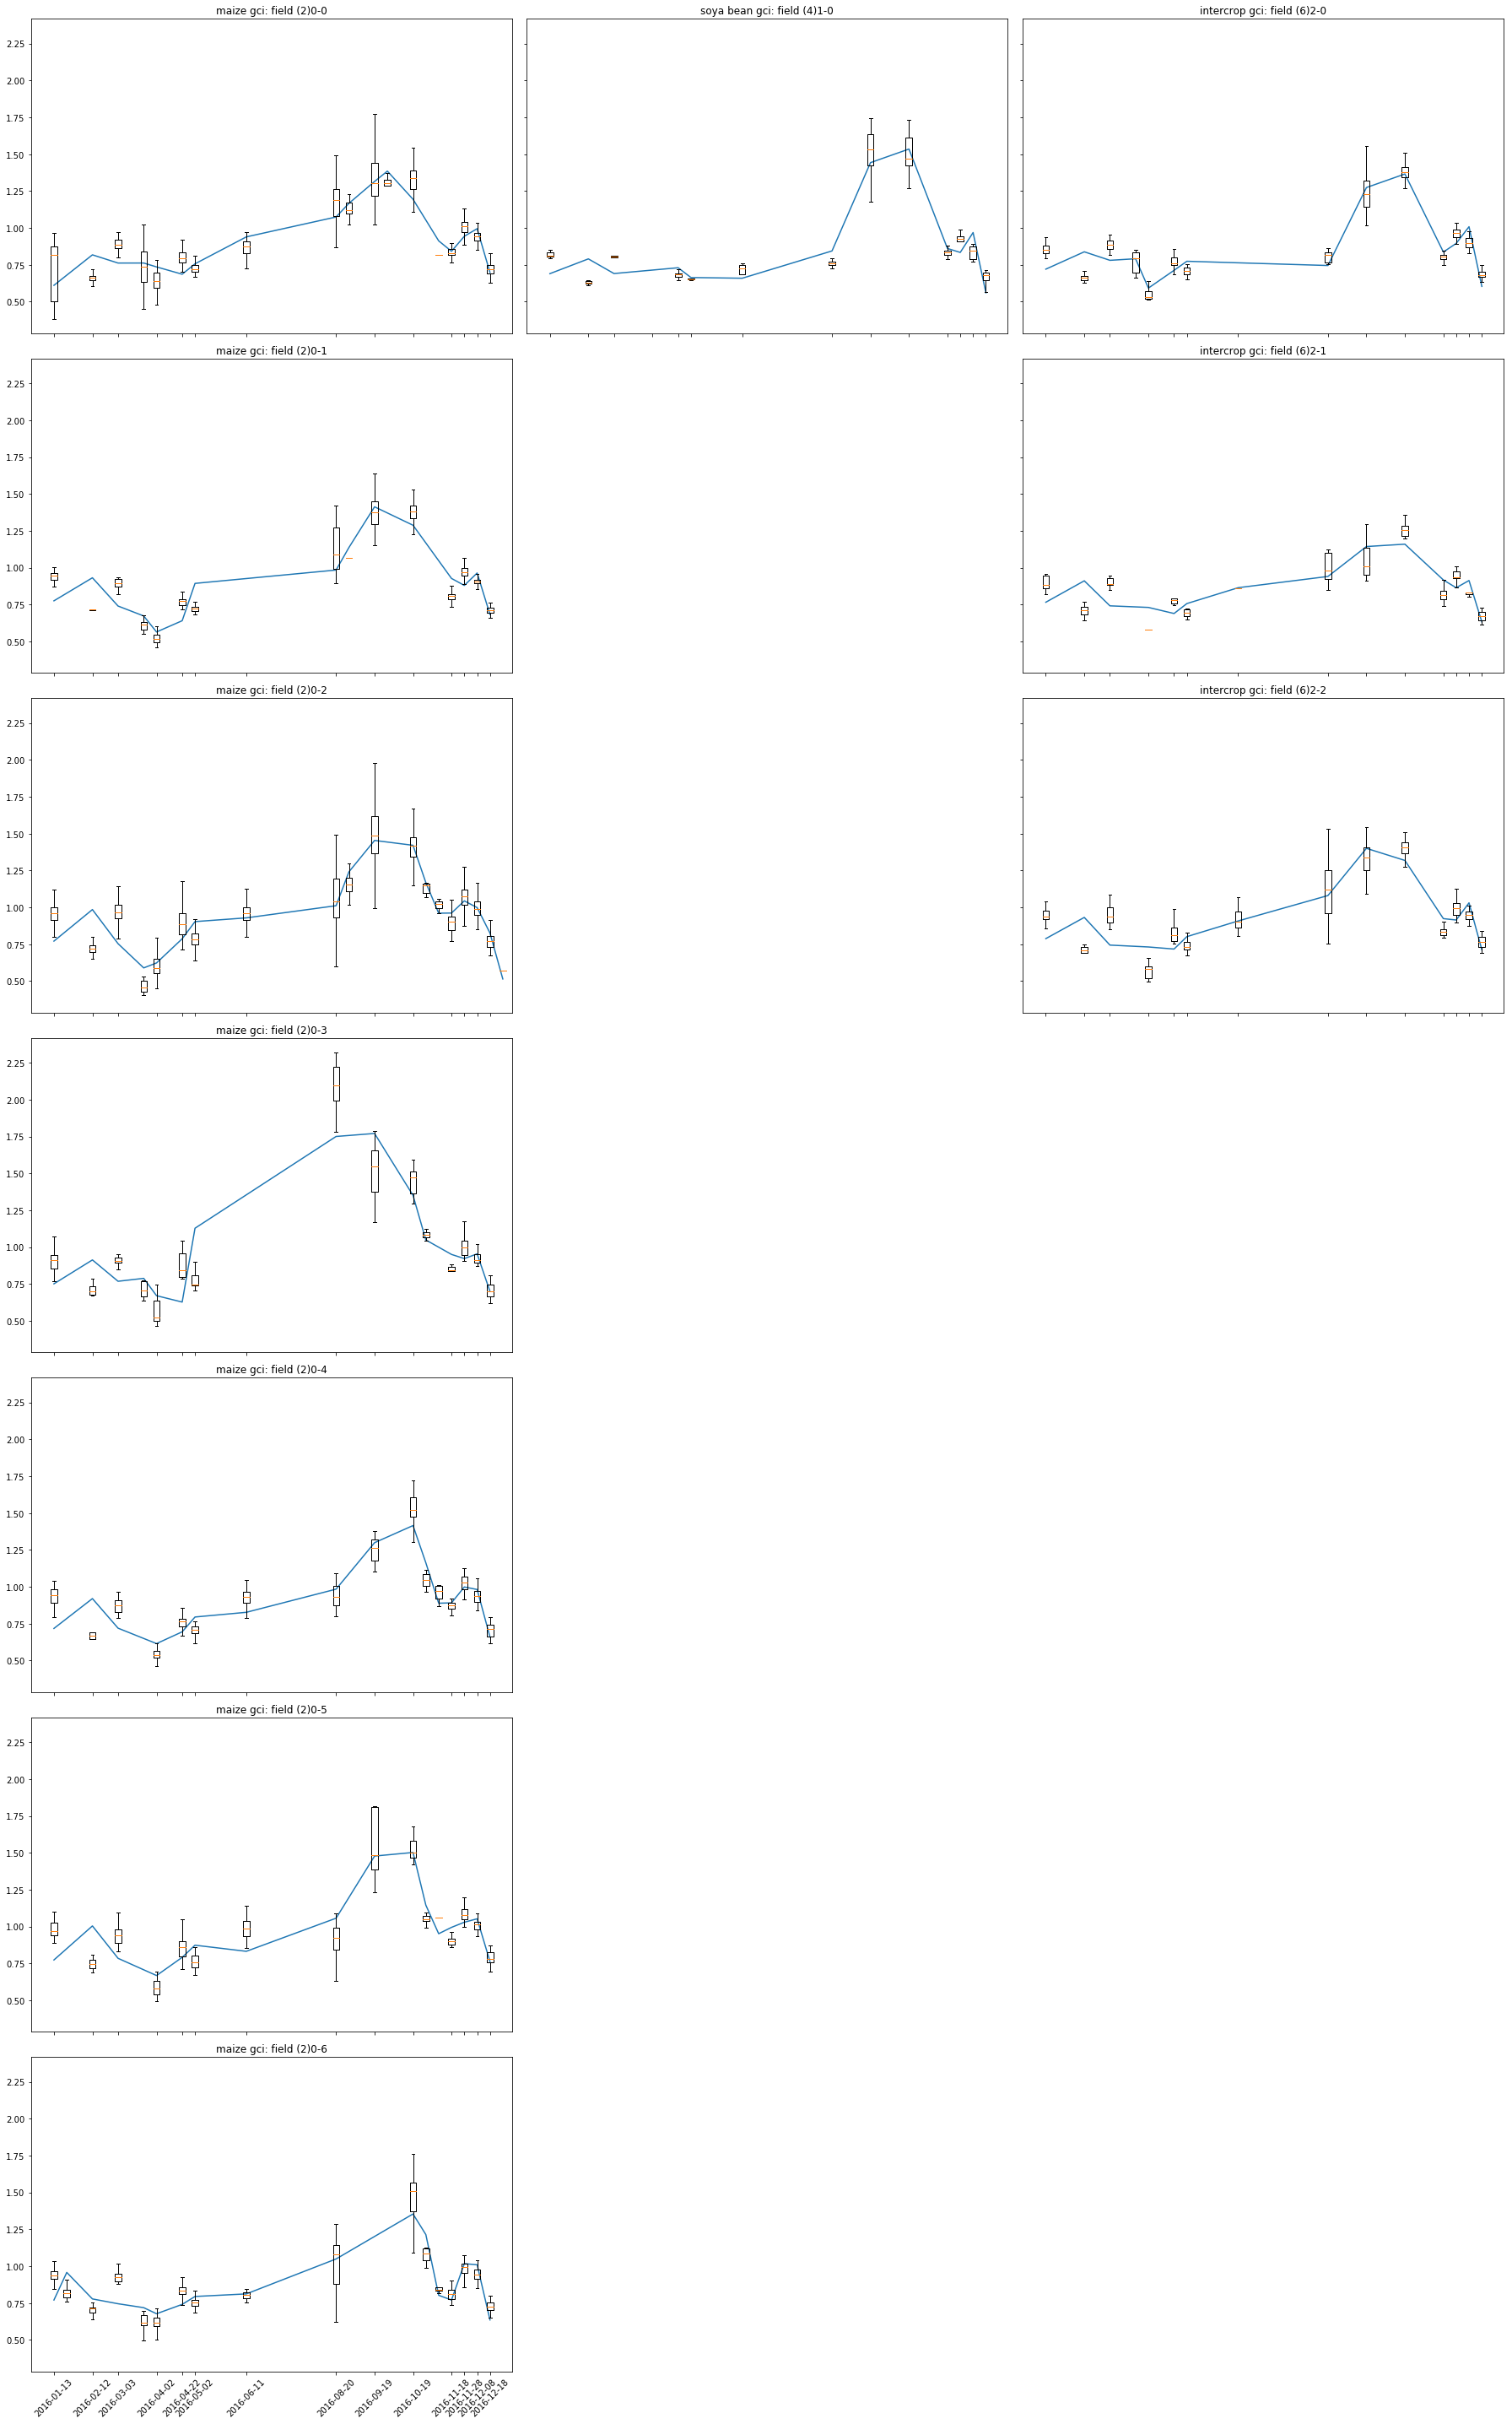

In [10]:
plotS2VI(fieldmasks,s2indices,s2dates,2,10)

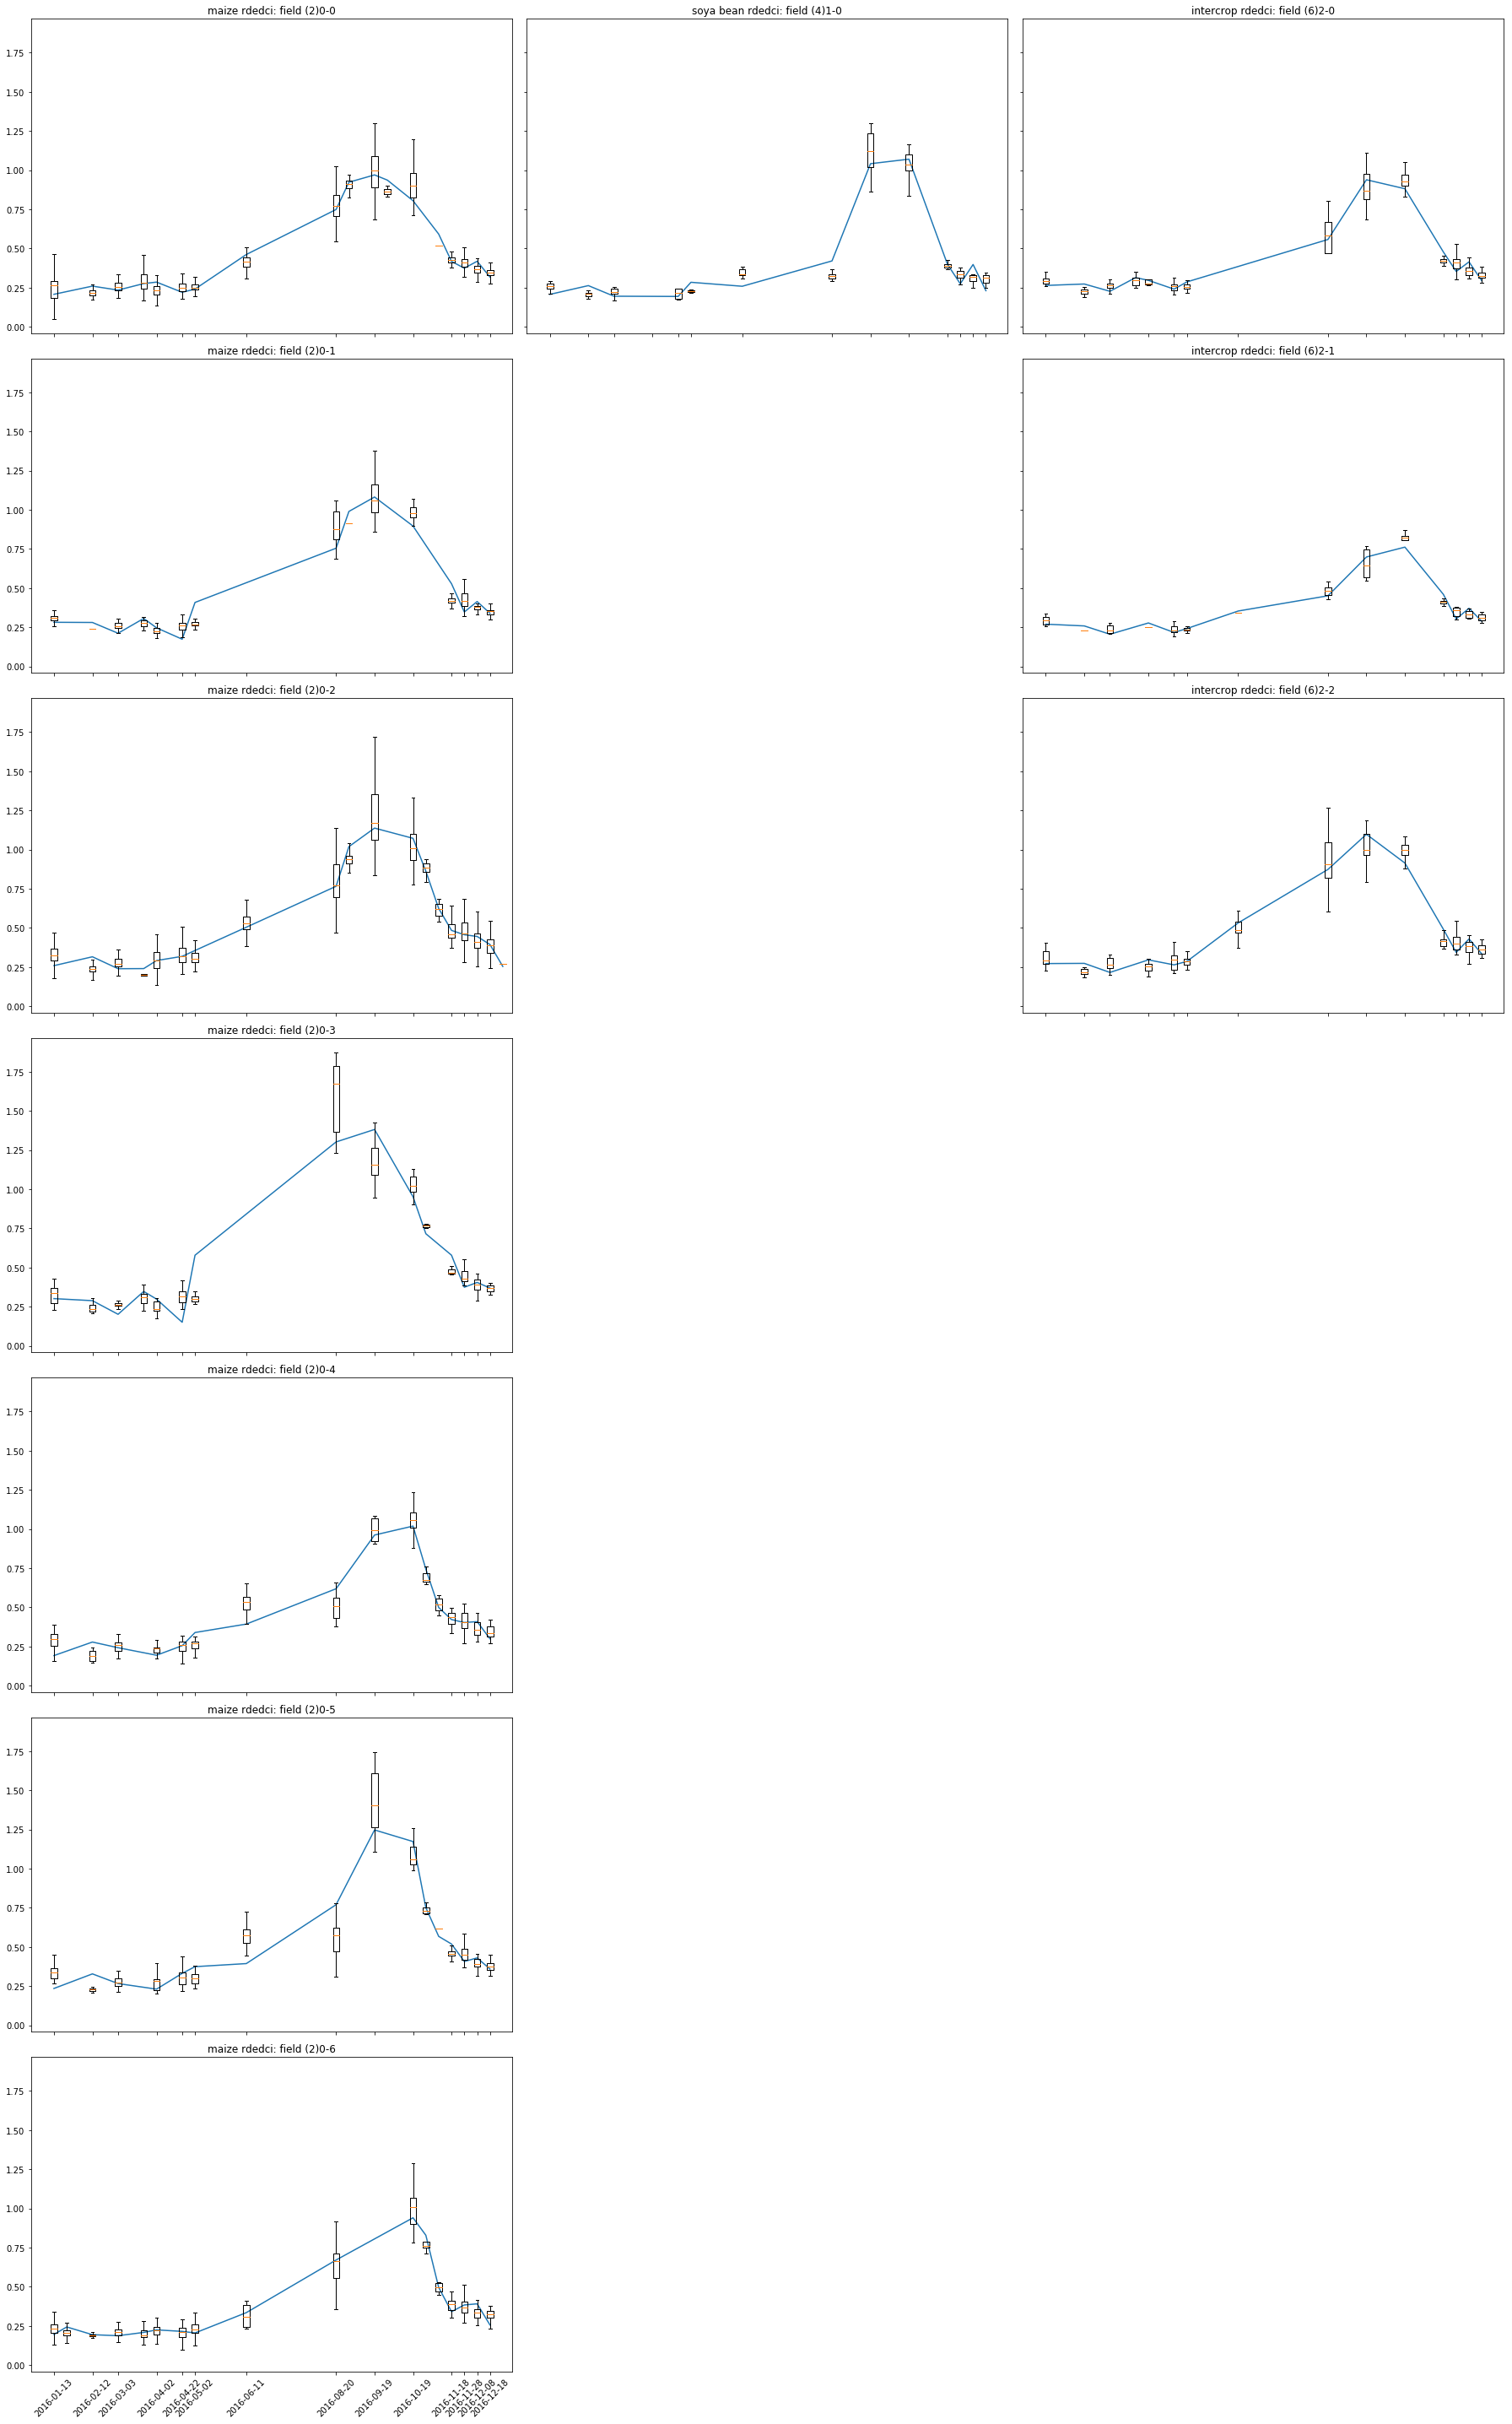

In [11]:
plotS2VI(fieldmasks,s2indices,s2dates,3,10)

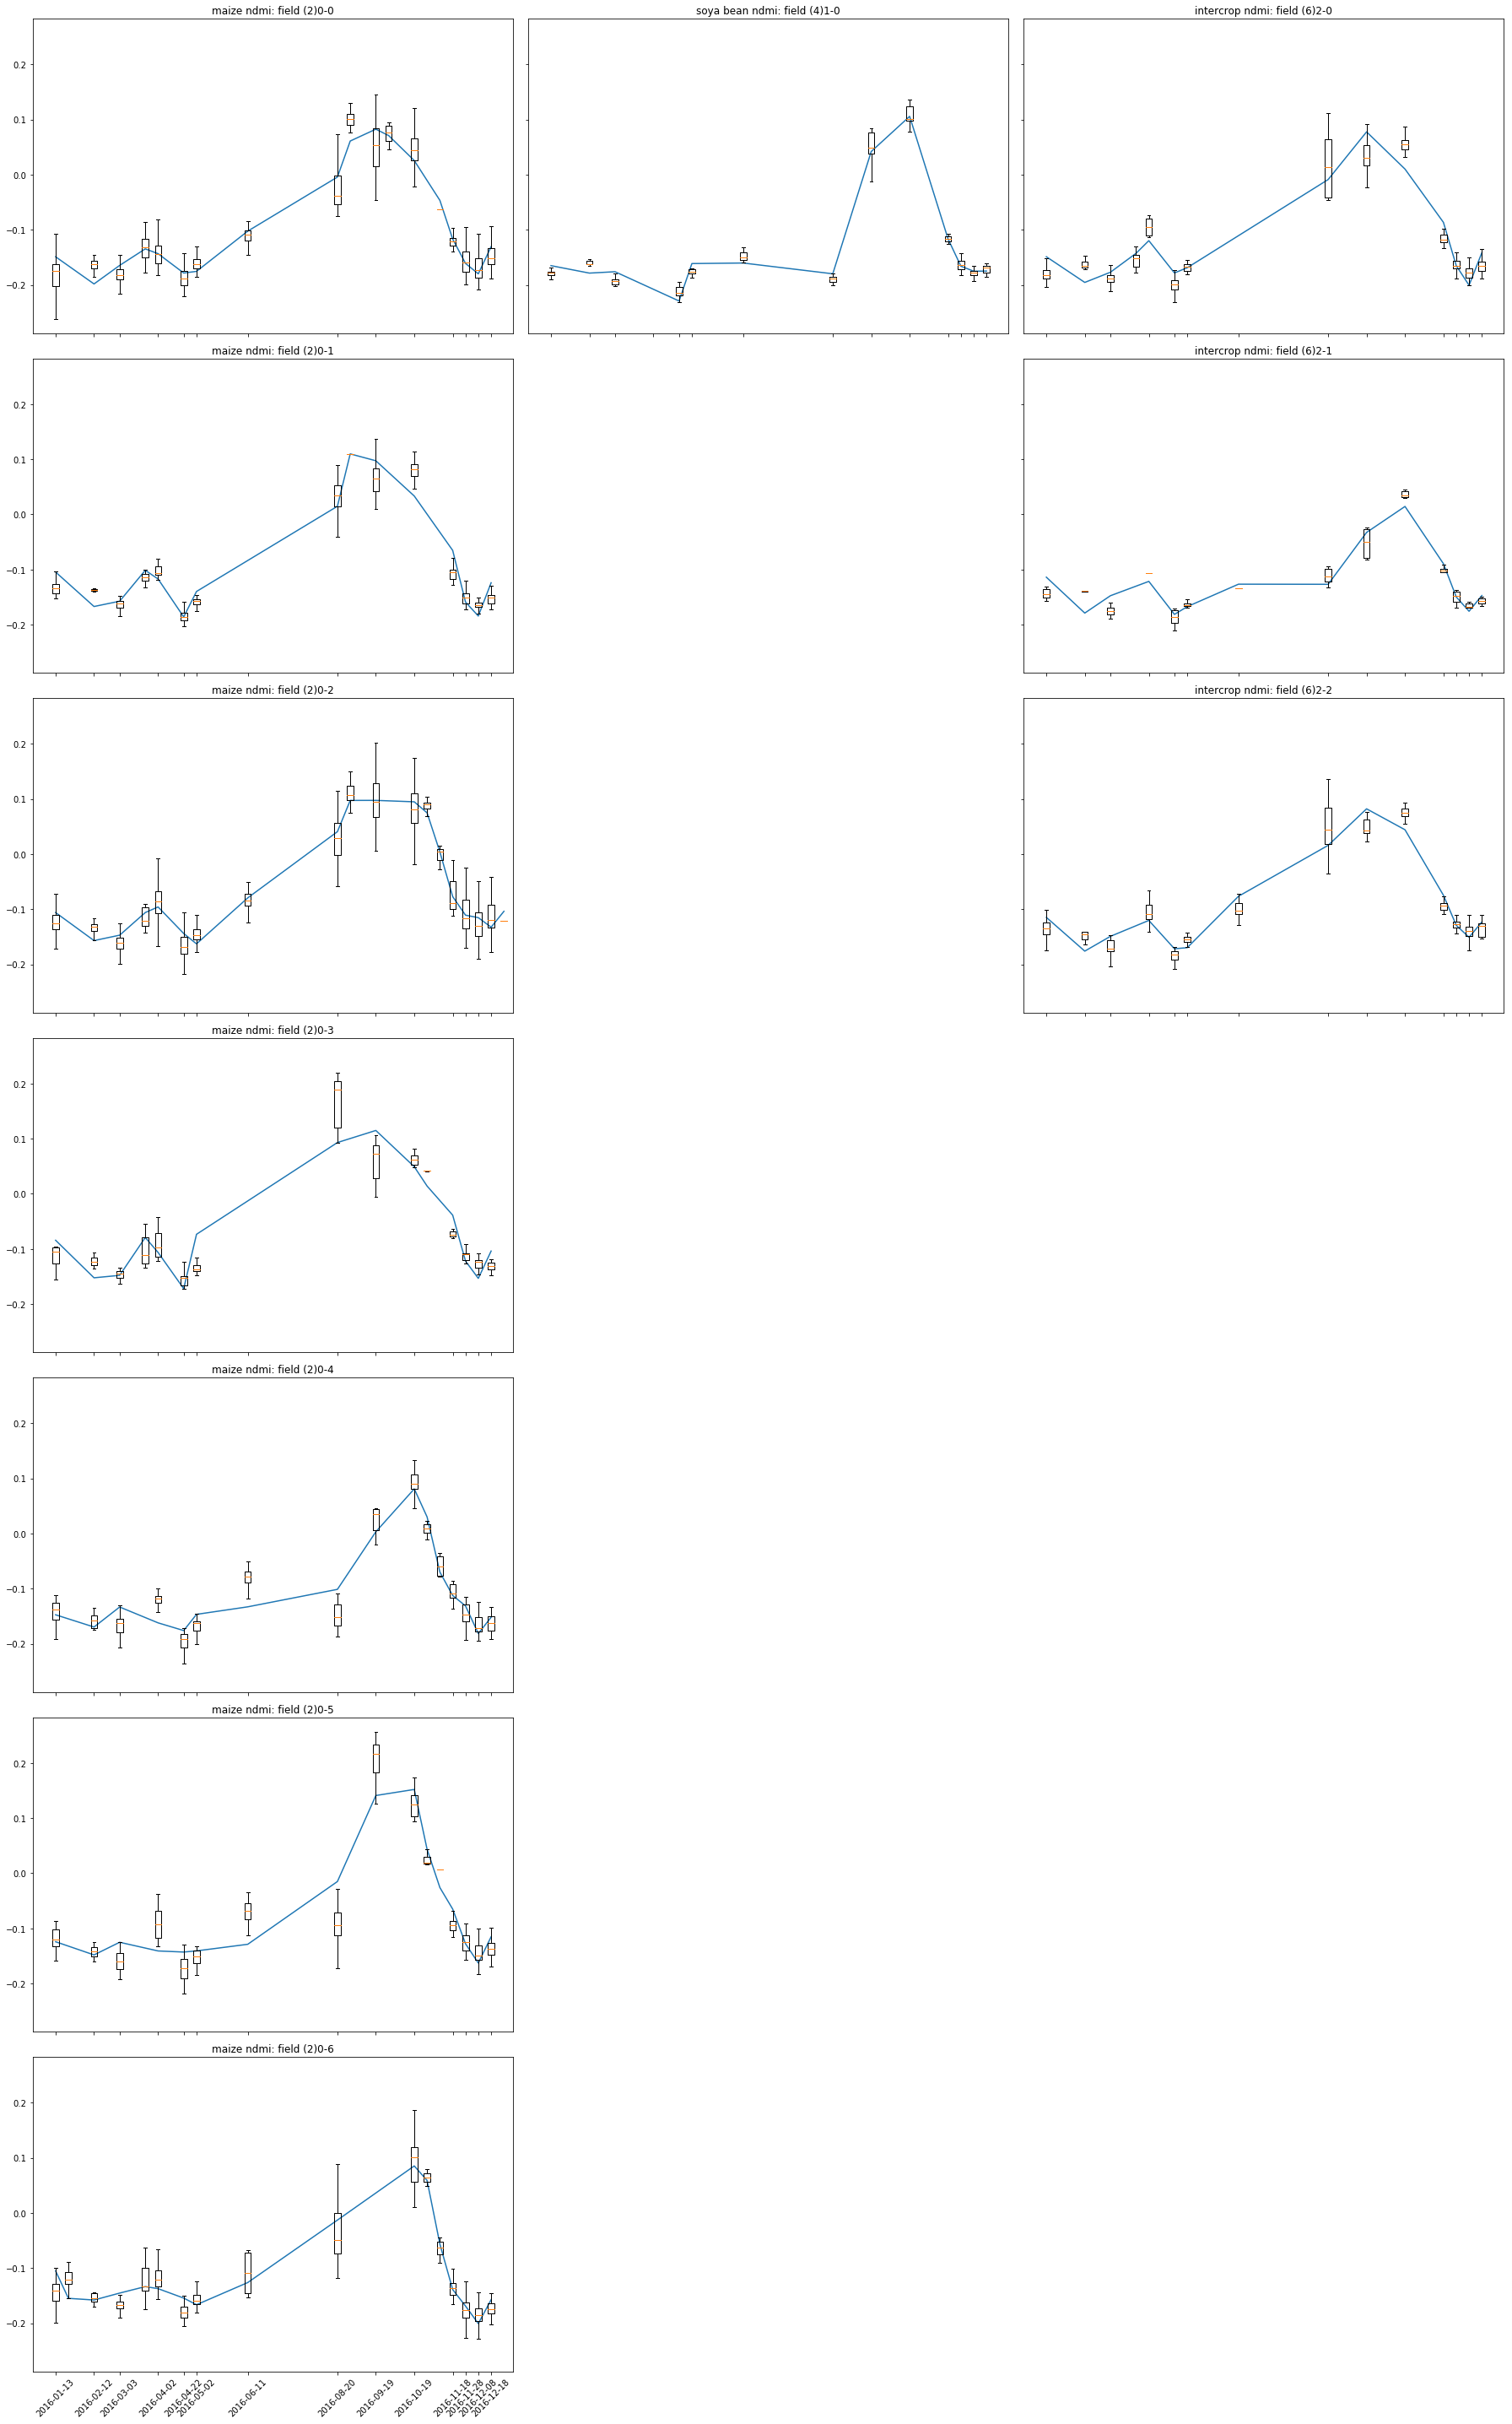

In [12]:
plotS2VI(fieldmasks,s2indices,s2dates,4,10)